In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch: 2.9.1+cpu
CUDA available: False


In [2]:
import urllib.request

images_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz"
annotations_url = "https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz"

print("Downloading images...")
urllib.request.urlretrieve(images_url, "images.tar.gz")
print("Downloading annotations...")
urllib.request.urlretrieve(annotations_url, "annotations.tar.gz")

print("Done!")

Done!


In [3]:
import tarfile

# extract images
with tarfile.open("images.tar.gz") as tar:
    tar.extractall()

# extract annotations
with tarfile.open("annotations.tar.gz") as tar:
    tar.extractall()

print("Extraction complete!")

Extraction complete!


In [4]:
import pandas as pd

rows = []

with open("annotations/list.txt", "r") as f:
    for line in f:
        line = line.strip()
        # Sărim peste liniile de comentariu care încep cu '#'
        if line.startswith("#") or not line:
            continue
        # Format: image_name class_id species breed_id
        name, class_id, species, breed_id = line.split()
        rows.append({
            "file": name,                # fără .jpg
            "class_id": int(class_id),
            "species": int(species),     # 1 = pisică, 2 = câine :contentReference[oaicite:0]{index=0}
            "breed_id": int(breed_id),
        })

df = pd.DataFrame(rows)
df.head()

file  class_id  species  breed_id
0  Abyssinian_100         1        1         1
1  Abyssinian_101         1        1         1
2  Abyssinian_102         1        1         1
3  Abyssinian_103         1        1         1
4  Abyssinian_104         1        1         1

In [5]:
cats_df = df[df["species"] == 1].copy().reset_index(drop=True)
cats_df.head(), len(cats_df), cats_df["class_id"].nunique()

(             file  class_id  species  breed_id
 0  Abyssinian_100         1        1         1
 1  Abyssinian_101         1        1         1
 2  Abyssinian_102         1        1         1
 3  Abyssinian_103         1        1         1
 4  Abyssinian_104         1        1         1,
 2371,
 12)

In [6]:
from pathlib import Path

image_dir = Path("images")

cats_df["image_path"] = cats_df["file"].apply(
    lambda name: image_dir / f"{name}.jpg"
)

cats_df["exists"] = cats_df["image_path"].apply(lambda p: p.is_file())
cats_df["exists"].value_counts()

exists
True    2371
Name: count, dtype: int64

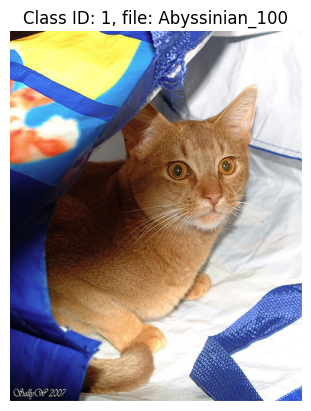

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

sample_row = cats_df.iloc[0]
img = Image.open(sample_row["image_path"])

plt.imshow(img)
plt.axis("off")
plt.title(f"Class ID: {sample_row['class_id']}, file: {sample_row['file']}")
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# stratify => păstrăm proporții similare de rase în fiecare split
train_df, temp_df = train_test_split(
    cats_df,
    test_size=0.3,
    stratify=cats_df["class_id"],
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["class_id"],
    random_state=42,
)

len(train_df), len(val_df), len(test_df)

(1659, 356, 356)

In [9]:
train_df["split"] = "train"
val_df["split"] = "val"
test_df["split"] = "test"

all_df = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)
all_df["split"].value_counts()

split
train    1659
val       356
test      356
Name: count, dtype: int64

In [10]:
all_df.to_csv("cats_labels.csv", index=False)

In [11]:
import pandas as pd
from pathlib import Path

df = pd.read_csv("cats_labels.csv")
df.head(), df["split"].value_counts()

(                    file  class_id  species  breed_id  \
 0             Siamese_44        33        1        11   
 1             Ragdoll_67        27        1         9   
 2  British_Shorthair_165        10        1         5   
 3         Abyssinian_120         1        1         1   
 4        Egyptian_Mau_81        12        1         6   
 
                          image_path  exists  split  
 0             images\Siamese_44.jpg    True  train  
 1             images\Ragdoll_67.jpg    True  train  
 2  images\British_Shorthair_165.jpg    True  train  
 3         images\Abyssinian_120.jpg    True  train  
 4        images\Egyptian_Mau_81.jpg    True  train  ,
 split
 train    1659
 val       356
 test      356
 Name: count, dtype: int64)

In [12]:
# lista de ID-uri de clasă (rase) existente
class_ids = sorted(df["class_id"].unique())
class_id_to_idx = {cid: i for i, cid in enumerate(class_ids)}
idx_to_class_id = {i: cid for cid, i in class_id_to_idx.items()}

df["label"] = df["class_id"].map(class_id_to_idx)

num_classes = len(class_ids)
print("Număr de rase (clase):", num_classes)
print("Mapping class_id -> label:", class_id_to_idx)

Număr de rase (clase): 12
Mapping class_id -> label: {np.int64(1): 0, np.int64(6): 1, np.int64(7): 2, np.int64(8): 3, np.int64(10): 4, np.int64(12): 5, np.int64(21): 6, np.int64(24): 7, np.int64(27): 8, np.int64(28): 9, np.int64(33): 10, np.int64(34): 11}


In [13]:
from torch.utils.data import Dataset
from PIL import Image

class CatBreedsDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = Path(row["image_path"])
        image = Image.open(img_path).convert("RGB")
        label = int(row["label"])

        if self.transform:
            image = self.transform(image)

        return image, label

In [14]:
import torchvision.transforms as T

In [15]:
image_size = 224
train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

val_test_transform = T.Compose([
    T.Resize((256, 256)),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

In [16]:
train_df = df[df["split"] == "train"].copy()
val_df   = df[df["split"] == "val"].copy()
test_df  = df[df["split"] == "test"].copy()

train_dataset = CatBreedsDataset(train_df, transform=train_transform)
val_dataset   = CatBreedsDataset(val_df,   transform=val_test_transform)
test_dataset  = CatBreedsDataset(test_df,  transform=val_test_transform)

len(train_dataset), len(val_dataset), len(test_dataset)

(1659, 356, 356)

In [17]:
from torch.utils.data import DataLoader

batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
)

In [18]:
import torch

images, labels = next(iter(train_loader))
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)
print("Labels sample:", labels[:10])

Images shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Labels sample: tensor([10,  9,  1,  9,  8,  5, 10, 11, 10,  7])


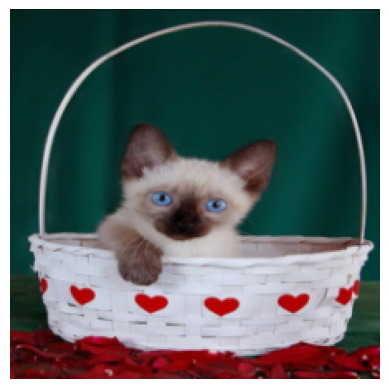

In [19]:
import matplotlib.pyplot as plt

def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img_tensor * std + mean

img = images[0]
img_dn = denormalize(img).clamp(0, 1)

plt.imshow(img_dn.permute(1, 2, 0).cpu().numpy())
plt.axis("off")
plt.show()

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision.models import resnet18, ResNet18_Weights

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [22]:
num_classes = len(class_ids)

In [23]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

print(model.fc)

Linear(in_features=512, out_features=12, bias=True)


In [24]:
import torchvision.models as models
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

C:\Users\Elisa\cat-breeds\catenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Elisa\cat-breeds\catenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT   # cele mai noi greutăți
model = resnet18(weights=weights)

in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

model = model.to(device)

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [27]:
from tqdm.auto import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for images, labels in tqdm(loader, desc="Eval", leave=False):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [28]:
num_epochs = 5  # poți crește ulterior
best_val_acc = 0.0
best_model_path = "best_cat_breeds_resnet18.pth"

for epoch in range(1, num_epochs + 1):
    print(f"Epoch {epoch}/{num_epochs}")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"  Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f} | Val   acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"  New best model saved (val_acc={val_acc:.4f})")

print("Training finished. Best val acc:", best_val_acc)

Epoch 1/5


Train:   0%|          | 0/52 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 1.0740 | Train acc: 0.6793
  Val   loss: 0.4373 | Val   acc: 0.8708
  New best model saved (val_acc=0.8708)
Epoch 2/5


Train:   0%|          | 0/52 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.3220 | Train acc: 0.9084
  Val   loss: 0.3516 | Val   acc: 0.8961
  New best model saved (val_acc=0.8961)
Epoch 3/5


Train:   0%|          | 0/52 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.1800 | Train acc: 0.9524
  Val   loss: 0.3055 | Val   acc: 0.9073
  New best model saved (val_acc=0.9073)
Epoch 4/5


Train:   0%|          | 0/52 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.1065 | Train acc: 0.9819
  Val   loss: 0.2718 | Val   acc: 0.9185
  New best model saved (val_acc=0.9185)
Epoch 5/5


Train:   0%|          | 0/52 [00:00<?, ?it/s]

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.0717 | Train acc: 0.9898
  Val   loss: 0.2437 | Val   acc: 0.9382
  New best model saved (val_acc=0.9382)
Training finished. Best val acc: 0.9382022471910112


In [29]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [30]:
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=None)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(device)

model.load_state_dict(torch.load(best_model_path, map_location=device))

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

Test loss: 0.2503 | Test acc: 0.9129


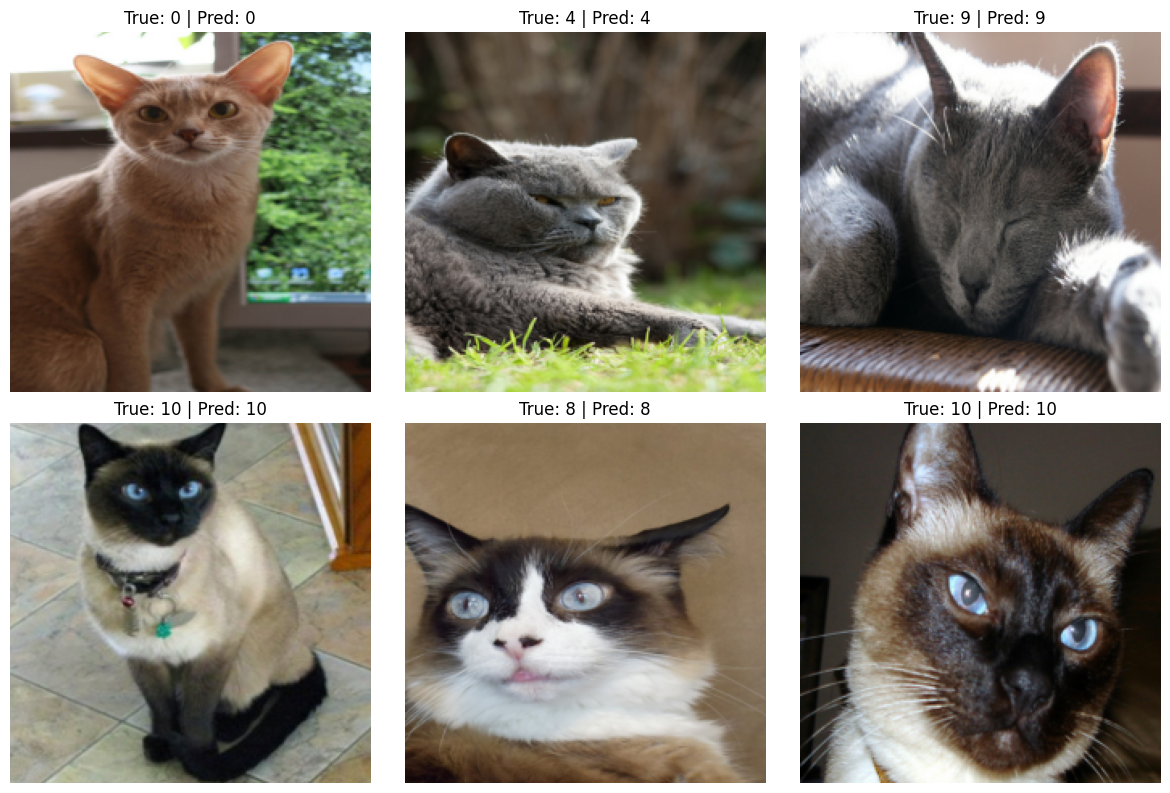

In [31]:
import matplotlib.pyplot as plt

model.eval()

images, labels = next(iter(test_loader))
images = images.to(device)
labels = labels.to(device)

with torch.inference_mode():
    outputs = model(images)
    _, preds = outputs.max(1)

def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    return img_tensor * std + mean

plt.figure(figsize=(12, 8))
for i in range(6):
    img = denormalize(images[i]).clamp(0, 1).cpu()
    label_idx = labels[i].item()
    pred_idx = preds[i].item()

    plt.subplot(2, 3, i+1)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.title(f"True: {label_idx} | Pred: {pred_idx}")
plt.tight_layout()
plt.show()

In [32]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

Eval:   0%|          | 0/12 [00:00<?, ?it/s]

Test loss: 0.2503 | Test acc: 0.9129


In [33]:
import pandas as pd

df = pd.read_csv("cats_labels.csv")
df.head()


file  class_id  species  breed_id  \
0             Siamese_44        33        1        11   
1             Ragdoll_67        27        1         9   
2  British_Shorthair_165        10        1         5   
3         Abyssinian_120         1        1         1   
4        Egyptian_Mau_81        12        1         6   

                         image_path  exists  split  
0             images\Siamese_44.jpg    True  train  
1             images\Ragdoll_67.jpg    True  train  
2  images\British_Shorthair_165.jpg    True  train  
3         images\Abyssinian_120.jpg    True  train  
4        images\Egyptian_Mau_81.jpg    True  train

In [34]:
breed_names = {}

for cid in sorted(df["class_id"].unique()):
    row = df[df["class_id"] == cid].iloc[0]
    file_name = row["file"]  # de ex. "Abyssinian_1"
    breed_name = file_name.rsplit("_", 1)[0]
    breed_names[cid] = breed_name

breed_names


{np.int64(1): 'Abyssinian',
 np.int64(6): 'Bengal',
 np.int64(7): 'Birman',
 np.int64(8): 'Bombay',
 np.int64(10): 'British_Shorthair',
 np.int64(12): 'Egyptian_Mau',
 np.int64(21): 'Maine_Coon',
 np.int64(24): 'Persian',
 np.int64(27): 'Ragdoll',
 np.int64(28): 'Russian_Blue',
 np.int64(33): 'Siamese',
 np.int64(34): 'Sphynx'}

In [35]:
class_ids = sorted(df["class_id"].unique())
class_id_to_idx = {cid: i for i, cid in enumerate(class_ids)}

label_to_breed = {class_id_to_idx[cid]: breed_names[cid] for cid in class_ids}

label_to_breed

{0: 'Abyssinian',
 1: 'Bengal',
 2: 'Birman',
 3: 'Bombay',
 4: 'British_Shorthair',
 5: 'Egyptian_Mau',
 6: 'Maine_Coon',
 7: 'Persian',
 8: 'Ragdoll',
 9: 'Russian_Blue',
 10: 'Siamese',
 11: 'Sphynx'}

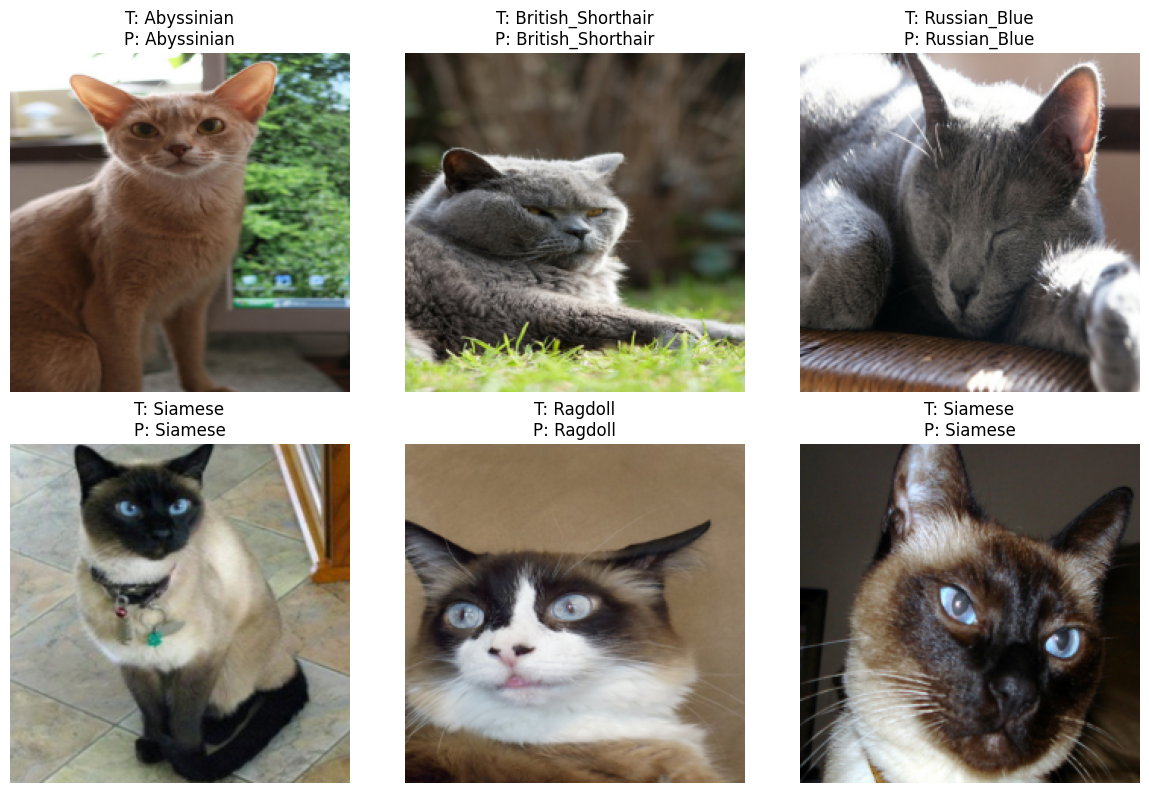

In [36]:
plt.figure(figsize=(12, 8))
for i in range(6):
    img = denormalize(images[i]).clamp(0, 1).cpu()
    label_idx = labels[i].item()
    pred_idx = preds[i].item()

    true_name = label_to_breed[label_idx]
    pred_name = label_to_breed[pred_idx]

    plt.subplot(2, 3, i+1)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.title(f"T: {true_name}\nP: {pred_name}")
plt.tight_layout()
plt.show()

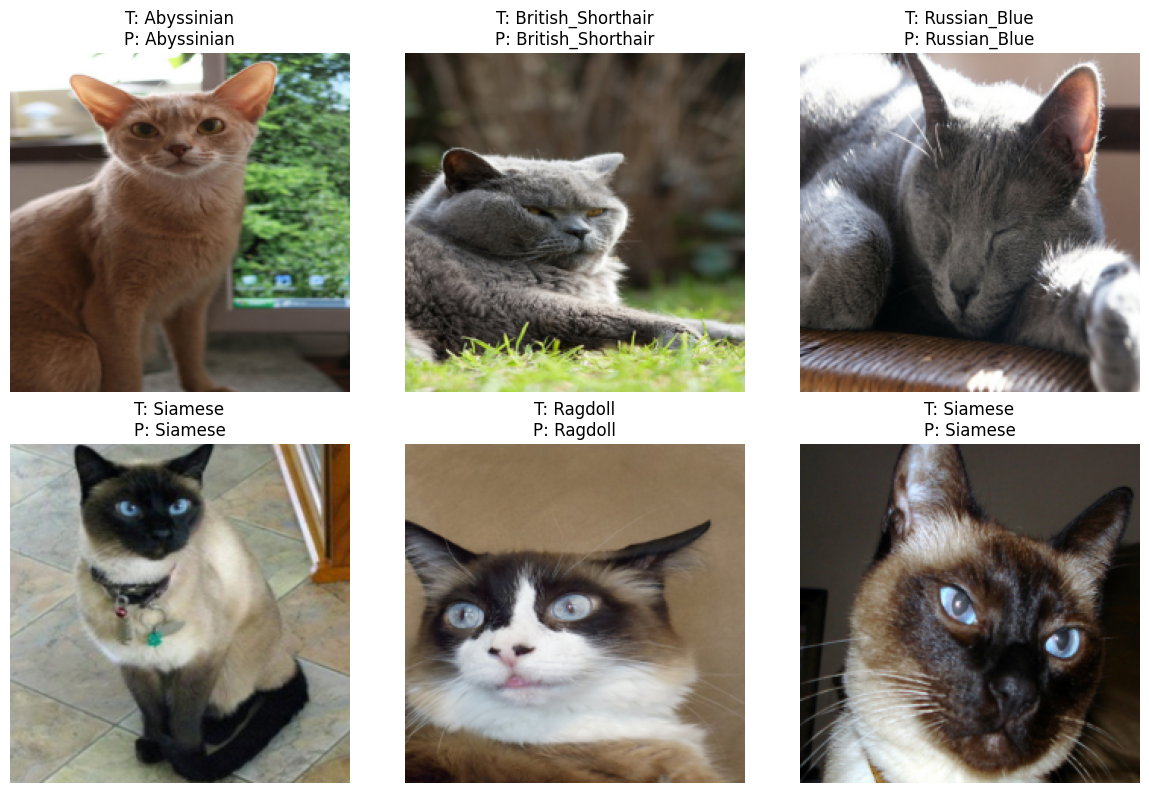

In [37]:
plt.figure(figsize=(12, 8))
for i in range(6):
    img = denormalize(images[i]).clamp(0, 1).cpu()
    label_idx = labels[i].item()
    pred_idx = preds[i].item()

    true_name = label_to_breed[label_idx]
    pred_name = label_to_breed[pred_idx]

    plt.subplot(2, 3, i+1)
    plt.imshow(img.permute(1, 2, 0).numpy())
    plt.axis("off")
    plt.title(f"T: {true_name}\nP: {pred_name}")
plt.tight_layout()

plt.savefig("sample_predictions.png", dpi=150)
plt.show()


In [38]:
from PIL import Image
import torch.nn.functional as F

def predict_image(image_path, model, transform, device, topk=3):
    model.eval()
    img = Image.open(image_path).convert("RGB")
    img_t = transform(img).unsqueeze(0).to(device)

    with torch.inference_mode():
        outputs = model(img_t)
        probs = F.softmax(outputs, dim=1)[0]

    top_probs, top_idxs = torch.topk(probs, topk)
    results = []
    for p, idx in zip(top_probs, top_idxs):
        idx = idx.item()
        breed_name = label_to_breed[idx]
        results.append((breed_name, float(p)))

    return img, results


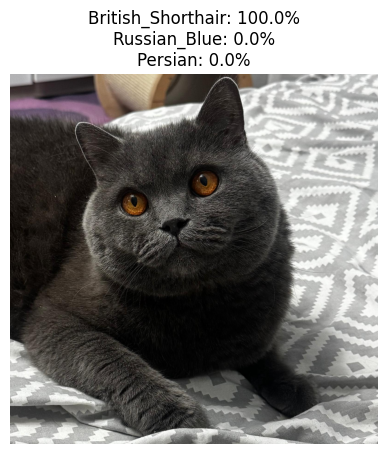

[('British_Shorthair', 0.9998966455459595), ('Russian_Blue', 2.9092432669131085e-05), ('Persian', 2.3734703063382767e-05)]


In [39]:
img, preds = predict_image("mycat.jpg", model, val_test_transform, device) 

plt.imshow(img)
plt.axis("off")
title = "\n".join([f"{breed}: {prob*100:.1f}%" for breed, prob in preds])
plt.title(title)
plt.savefig("single_prediction.png", dpi=150)
plt.show()

print(preds)


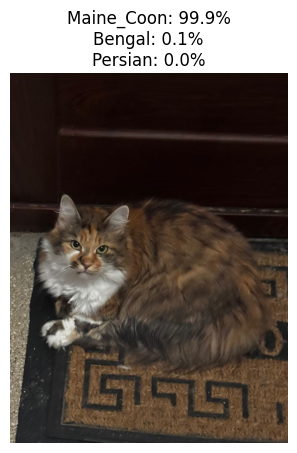

[('Maine_Coon', 0.998874843120575), ('Bengal', 0.0007014757138676941), ('Persian', 0.00029102989356033504)]


In [40]:
img, preds = predict_image("neighborscat.jpg", model, val_test_transform, device) 

plt.imshow(img)
plt.axis("off")
title = "\n".join([f"{breed}: {prob*100:.1f}%" for breed, prob in preds])
plt.title(title)
plt.savefig("single_prediction.png", dpi=150)
plt.show()

print(preds)


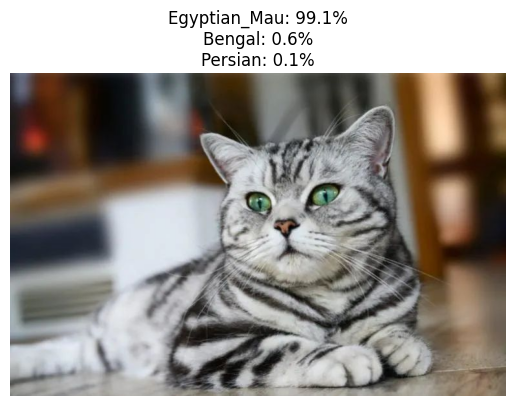

[('Egyptian_Mau', 0.9907127022743225), ('Bengal', 0.006024204194545746), ('Persian', 0.0008560826536267996)]


In [41]:
img, preds = predict_image("silvertabby.jpg", model, val_test_transform, device) 

plt.imshow(img)
plt.axis("off")
title = "\n".join([f"{breed}: {prob*100:.1f}%" for breed, prob in preds])
plt.title(title)
plt.savefig("single_prediction.png", dpi=150)
plt.show()

print(preds)


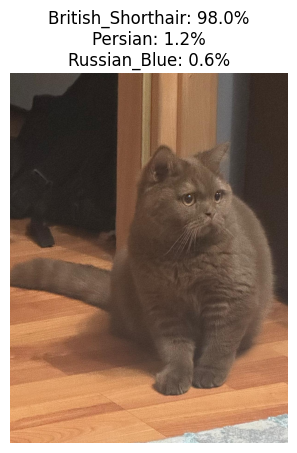

[('British_Shorthair', 0.9799647331237793), ('Persian', 0.011897512711584568), ('Russian_Blue', 0.0056678480468690395)]


In [42]:
img, preds = predict_image("chococat.jpg", model, val_test_transform, device) 

plt.imshow(img)
plt.axis("off")
title = "\n".join([f"{breed}: {prob*100:.1f}%" for breed, prob in preds])
plt.title(title)
plt.savefig("single_prediction.png", dpi=150)  # pentru PPT
plt.show()

print(preds)


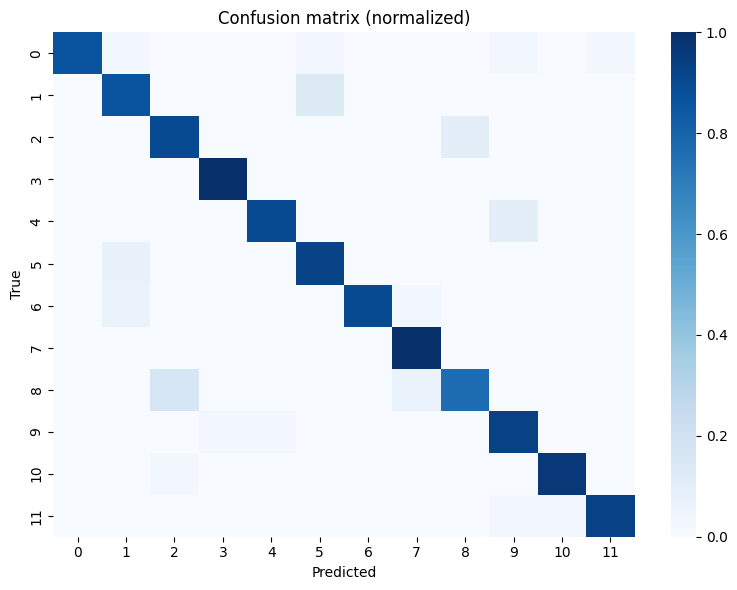

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

all_labels = []
all_preds = []

model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        outputs = model(images.to(device))
        _, preds = outputs.max(1)
        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix (normalized)")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()


In [44]:
!pip install seaborn


[notice] A new release of pip available: 22.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [45]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

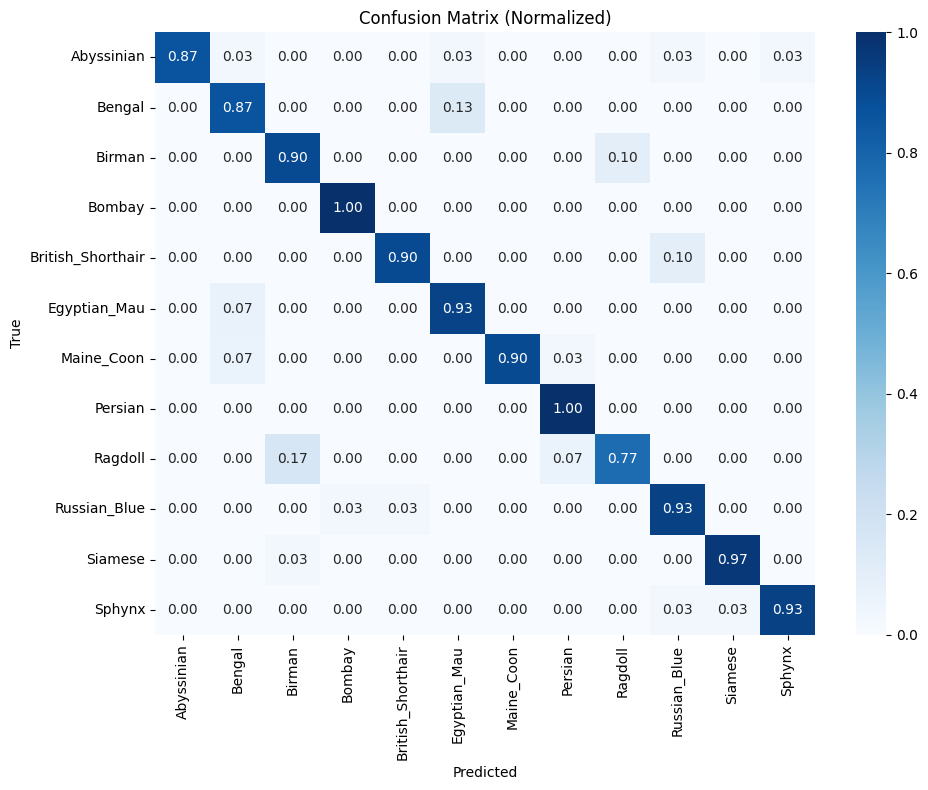

In [46]:
all_labels = []
all_preds = []

model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = outputs.max(1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
cm_norm = cm / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[label_to_breed[i] for i in range(num_classes)],
    yticklabels=[label_to_breed[i] for i in range(num_classes)]
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Normalized)")
plt.tight_layout()
plt.savefig("confusion_matrix.png", dpi=150)
plt.show()

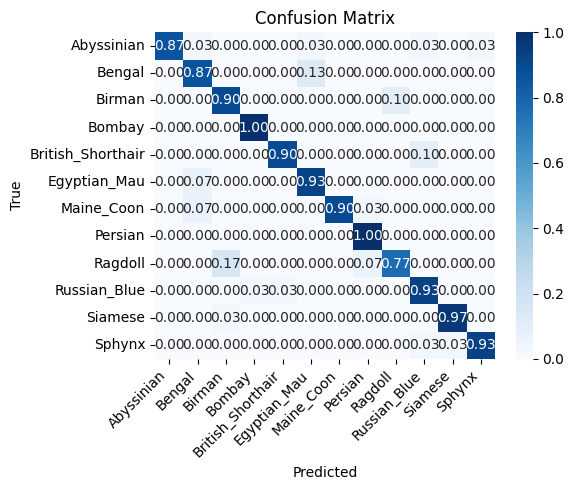

In [47]:
fig, ax = plt.subplots(figsize=(6, 5))  # mai mică
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[label_to_breed[i] for i in range(num_classes)],
    yticklabels=[label_to_breed[i] for i in range(num_classes)],
    ax=ax
)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()

fig.savefig("confusion_matrix_small.png", dpi=120, bbox_inches="tight")
plt.show()


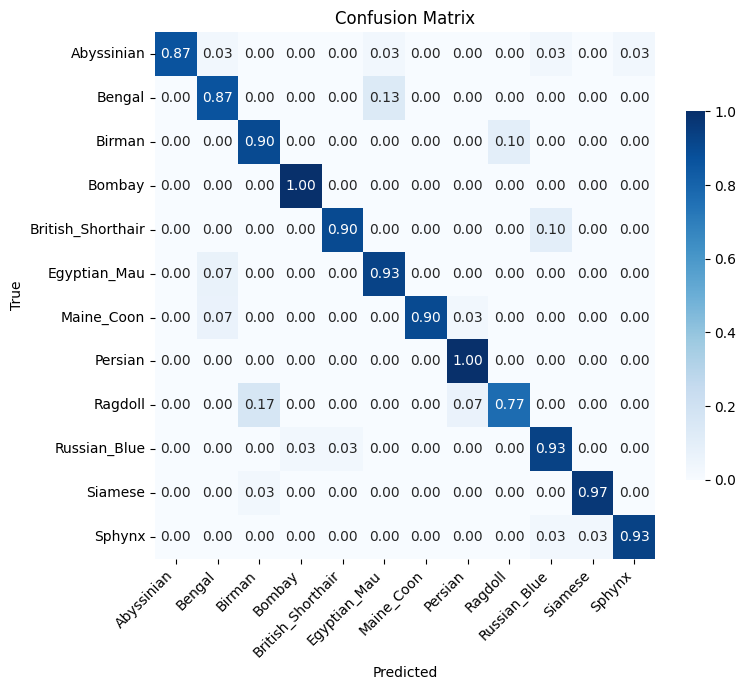

In [48]:
fig, ax = plt.subplots(figsize=(8, 7))

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=[label_to_breed[i] for i in range(num_classes)],
    yticklabels=[label_to_breed[i] for i in range(num_classes)],
    ax=ax,
    cbar_kws={"shrink": 0.7}
)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()

fig.savefig("confusion_matrix_medium.png", dpi=150, bbox_inches="tight")
plt.show()


In [49]:
import matplotlib.pyplot as plt



plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker="o")
plt.plot(val_losses, label="Validation Loss", marker="o")
plt.title("Train vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("loss_curve.png", dpi=150)
plt.show()


plt.figure(figsize=(8,5))
plt.plot(train_accs, label="Train Accuracy", marker="o")
plt.plot(val_accs, label="Validation Accuracy", marker="o")
plt.title("Train vs Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_curve.png", dpi=150)
plt.show()


NameError: name 'train_losses' is not defined

<Figure size 800x500 with 0 Axes>

In [ ]:
print("train_loader =", "OK" if 'train_loader' in globals() else "Missing")
print("val_loader   =", "OK" if 'val_loader' in globals() else "Missing")
print("test_loader  =", "OK" if 'test_loader' in globals() else "Missing")
print("model        =", "OK" if 'model' in globals() else "Missing")

In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def evaluate_loader(model, loader, device):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * labels.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = running_loss / total
    avg_acc = correct / total
    return avg_loss, avg_acc


train_loss, train_acc = evaluate_loader(model, train_loader, device)
val_loss, val_acc     = evaluate_loader(model, val_loader, device)
test_loss, test_acc   = evaluate_loader(model, test_loader, device)

print(f"Train   - loss: {train_loss:.4f} | acc: {train_acc:.4f}")
print(f"Val     - loss: {val_loss:.4f} | acc: {val_acc:.4f}")
print(f"Test    - loss: {test_loss:.4f} | acc: {test_acc:.4f}")

splits = ["Train", "Val", "Test"]
accs   = [train_acc, val_acc, test_acc]
losses = [train_loss, val_loss, test_loss]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Accuracy
axes[0].bar(splits, accs)
axes[0].set_ylim(0, 1)
axes[0].set_title("Accuracy pe fiecare set")
axes[0].set_ylabel("Accuracy")
for i, v in enumerate(accs):
    axes[0].text(i, v + 0.01, f"{v*100:.1f}%", ha="center")

# Loss
axes[1].bar(splits, losses)
axes[1].set_title("Loss pe fiecare set")
axes[1].set_ylabel("Loss")
for i, v in enumerate(losses):
    axes[1].text(i, v + 0.01, f"{v:.2f}", ha="center")

plt.tight_layout()
plt.savefig("performance_barplots.png", dpi=150)
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# ------------------------------
# Accuracy pe fiecare set
# ------------------------------
plt.figure(figsize=(8,5))
plt.bar(splits, accs, color="#D2B48C")
plt.ylim(0, 1)
plt.title("Accuracy pe fiecare set")
plt.ylabel("Accuracy")

for i, v in enumerate(accs):
    plt.text(i, v + 0.01, f"{v*100:.1f}%", ha="center")

plt.tight_layout()
plt.savefig("accuracy_curve_beige.png", dpi=150)
plt.show()

# ------------------------------
# Loss pe fiecare set
# ------------------------------
plt.figure(figsize=(8,5))
plt.bar(splits, losses, color="#D2B48C")
plt.title("Loss pe fiecare set")
plt.ylabel("Loss")

for i, v in enumerate(losses):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center")

plt.tight_layout()
plt.savefig("loss_curve_beige.png", dpi=150)
plt.show()


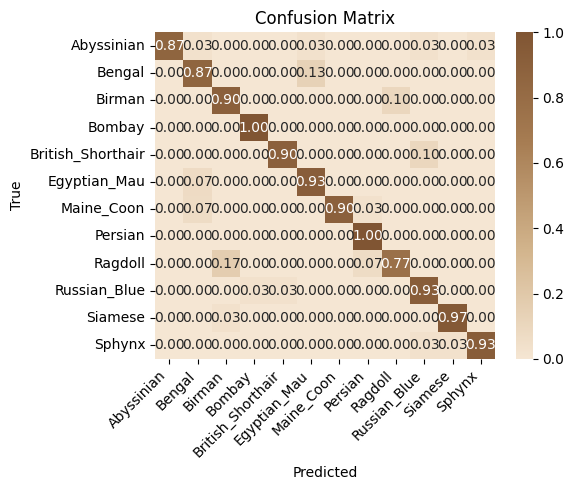

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

colors = ["#f5e6d3", "#d2b48c", "#a67c52", "#805533"]
cmap_bej = LinearSegmentedColormap.from_list("cmap_bej", colors)

fig, ax = plt.subplots(figsize=(6, 5))

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap=cmap_bej,              # ← NOUL COLORMAP
    xticklabels=[label_to_breed[i] for i in range(num_classes)],
    yticklabels=[label_to_breed[i] for i in range(num_classes)],
    ax=ax
)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

plt.xticks(rotation=45, ha="right")
plt.tight_layout()

fig.savefig("confusion_matrix_bej.png", dpi=120, bbox_inches="tight")
plt.show()


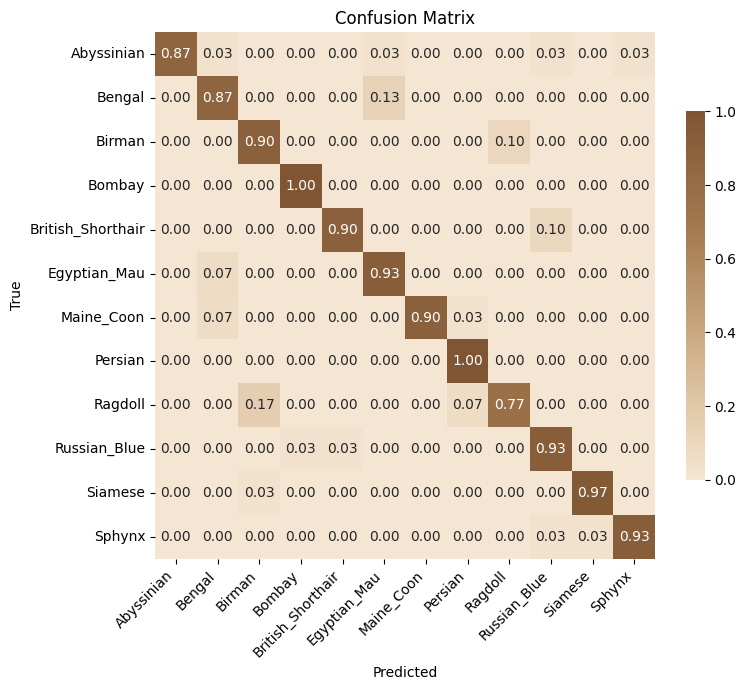

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

colors = ["#f5e6d3", "#d2b48c", "#a67c52", "#805533"]
cmap_bej = LinearSegmentedColormap.from_list("cmap_bej", colors)

fig, ax = plt.subplots(figsize=(8, 7))  # puțin mai mare decât înainte

sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap=cmap_bej,   # ← aici înlocuiești cu paleta bej
    xticklabels=[label_to_breed[i] for i in range(num_classes)],
    yticklabels=[label_to_breed[i] for i in range(num_classes)],
    ax=ax,
    cbar_kws={"shrink": 0.7}
)

ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_title("Confusion Matrix")

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()

fig.savefig("confusion_matrix_medium_bej.png", dpi=150, bbox_inches="tight")
plt.show()
